In [1]:
import numpy as np
import pandas as pd

import dask.dataframe as dd
from pathlib import Path
import datetime as dt

import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
import sys

sys.path.append("../src")

In [3]:
import data_handling as dh
import subsampling as ss
from cfg import get_config
import plotting
import pipeline

In [4]:
freq_group = ''
site_key = "Central"
cycle_lengths = [1800, 360]
percent_ons = [0.1667]
specific_dc_tag = "60of360"

In [5]:
cfg = get_config()
cfg["read_csv"] = False
cfg["save_activity_grid"] = True
cfg["save_presence_grid"] = True
cfg["save_dc_night_comparisons"] = True
cfg["save_activity_dc_comparisons"] = True
cfg["save_presence_dc_comparisons"] = True
cfg["show_plots"] = False
cfg["show_PST"] = True
cfg

{'dc_color_mappings': {'1800of1800': 'cyan',
  '60of360': 'red',
  '300of1800': 'orange'},
 'site_names': {'Central': 'Central Pond',
  'Foliage': 'Foliage',
  'Carp': 'Carp Pond',
  'Telephone': 'Telephone Field',
  'Opposite': 'Opposite Carp Pond',
  'Fallen': 'Fallen Tree'},
 'freq_groups': {'lf_': [0, 46000], 'hf_': [35000, 125000], '': [0, 125000]},
 'read_csv': False,
 'save_activity_grid': True,
 'save_presence_grid': True,
 'save_dc_night_comparisons': True,
 'save_activity_dc_comparisons': True,
 'save_presence_dc_comparisons': True,
 'show_plots': False,
 'show_PST': True}

In [6]:
data_params = dict()
data_params["site_name"] = cfg['site_names'][site_key]
data_params["site_tag"] = site_key
data_params["type_tag"] = freq_group
data_params["freq_tags"] = cfg['freq_groups'][freq_group]
data_params["cycle_lengths"] = cycle_lengths
data_params["percent_ons"] = percent_ons
dc_tags = ss.get_list_of_dc_tags(data_params["cycle_lengths"], data_params["percent_ons"])
data_params["dc_tags"] = dc_tags
data_params["cur_dc_tag"] = specific_dc_tag
data_params

{'site_name': 'Telephone Field',
 'site_tag': 'Telephone',
 'type_tag': '',
 'freq_tags': [0, 125000],
 'cycle_lengths': [1800, 360],
 'percent_ons': [0.1667],
 'dc_tags': ['1800of1800', '300of1800', '60of360'],
 'cur_dc_tag': '60of360'}

In [7]:
# csv_filename = f'dc__{data_params["type_tag"]}{data_params["site_tag"]}_summary.csv'
# rel_filepath = f'../data/2022_bd2_summary/{data_params["site_tag"]}/duty_cycled/{csv_filename}'
# activity_arr = pd.read_csv(f'{rel_filepath}', index_col=0)
# plotting.plot_dc_comparisons_per_night(activity_arr, data_params, cfg)

,Number_of_Detections (1800of1800),Number_of_Detections (300of1800),Number_of_Detections (60of360)
Date_and_Time_UTC,,,
2022-08-19 03:00:00,0.0,0.0,0.0
2022-08-19 03:30:00,1521.0,0.0,333.0
2022-08-19 04:00:00,154.0,110.0,4.0
2022-08-19 04:30:00,89.0,3.0,3.0
2022-08-19 05:00:00,56.0,0.0,2.0
...,...,...,...
2022-08-29 11:00:00,0.0,0.0,0.0
2022-08-29 11:30:00,18.0,0.0,0.0
2022-08-29 12:00:00,19.0,0.0,0.0


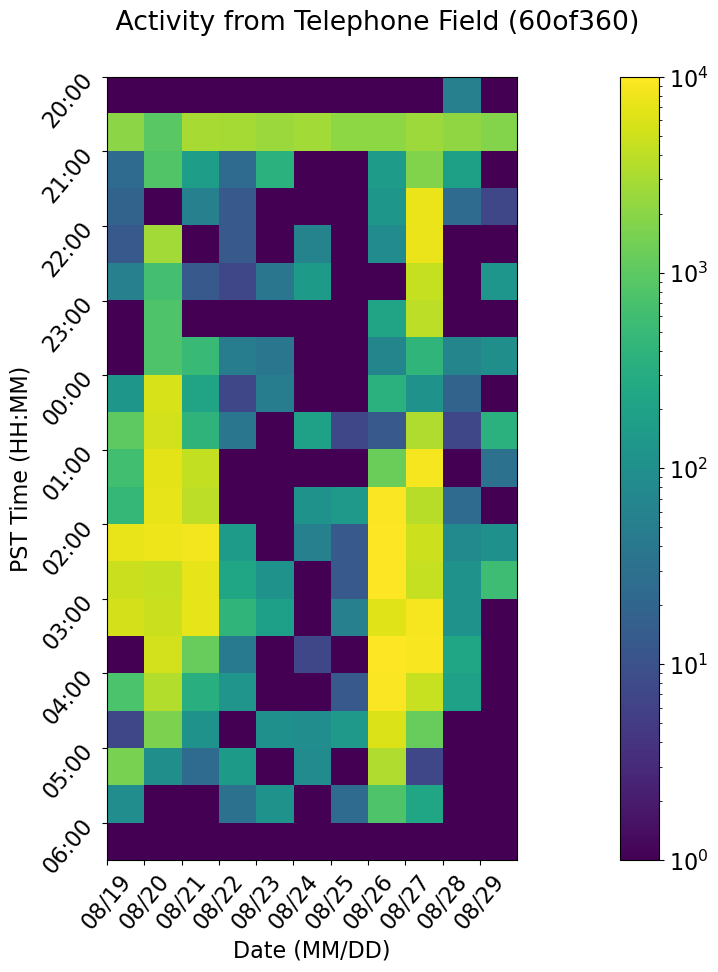

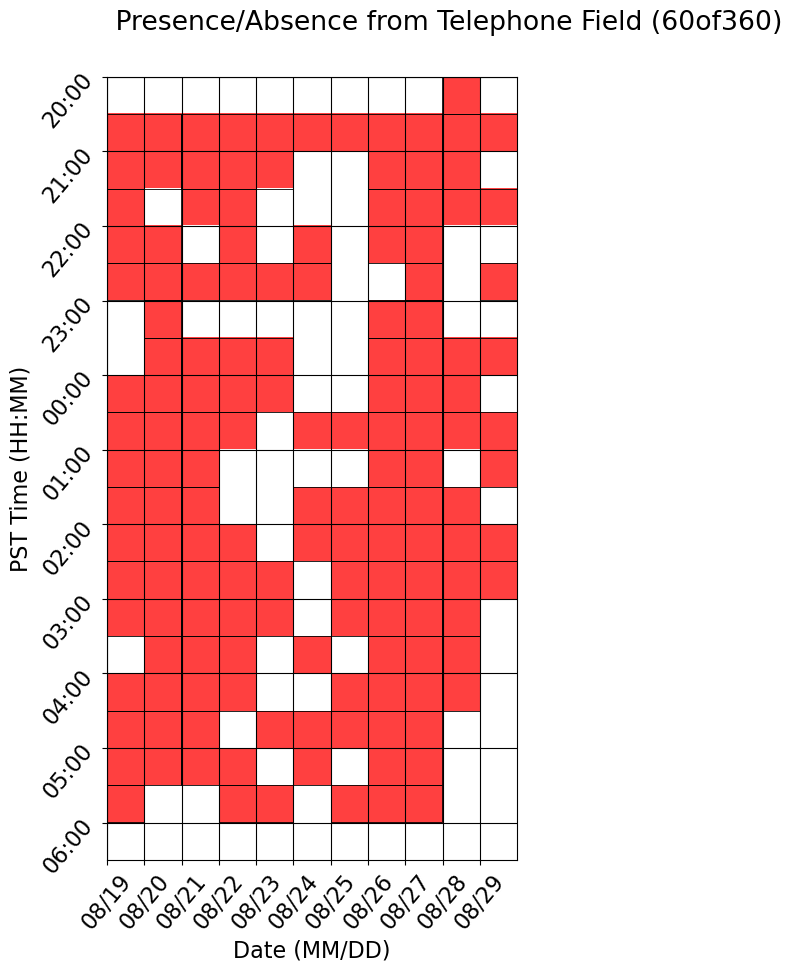

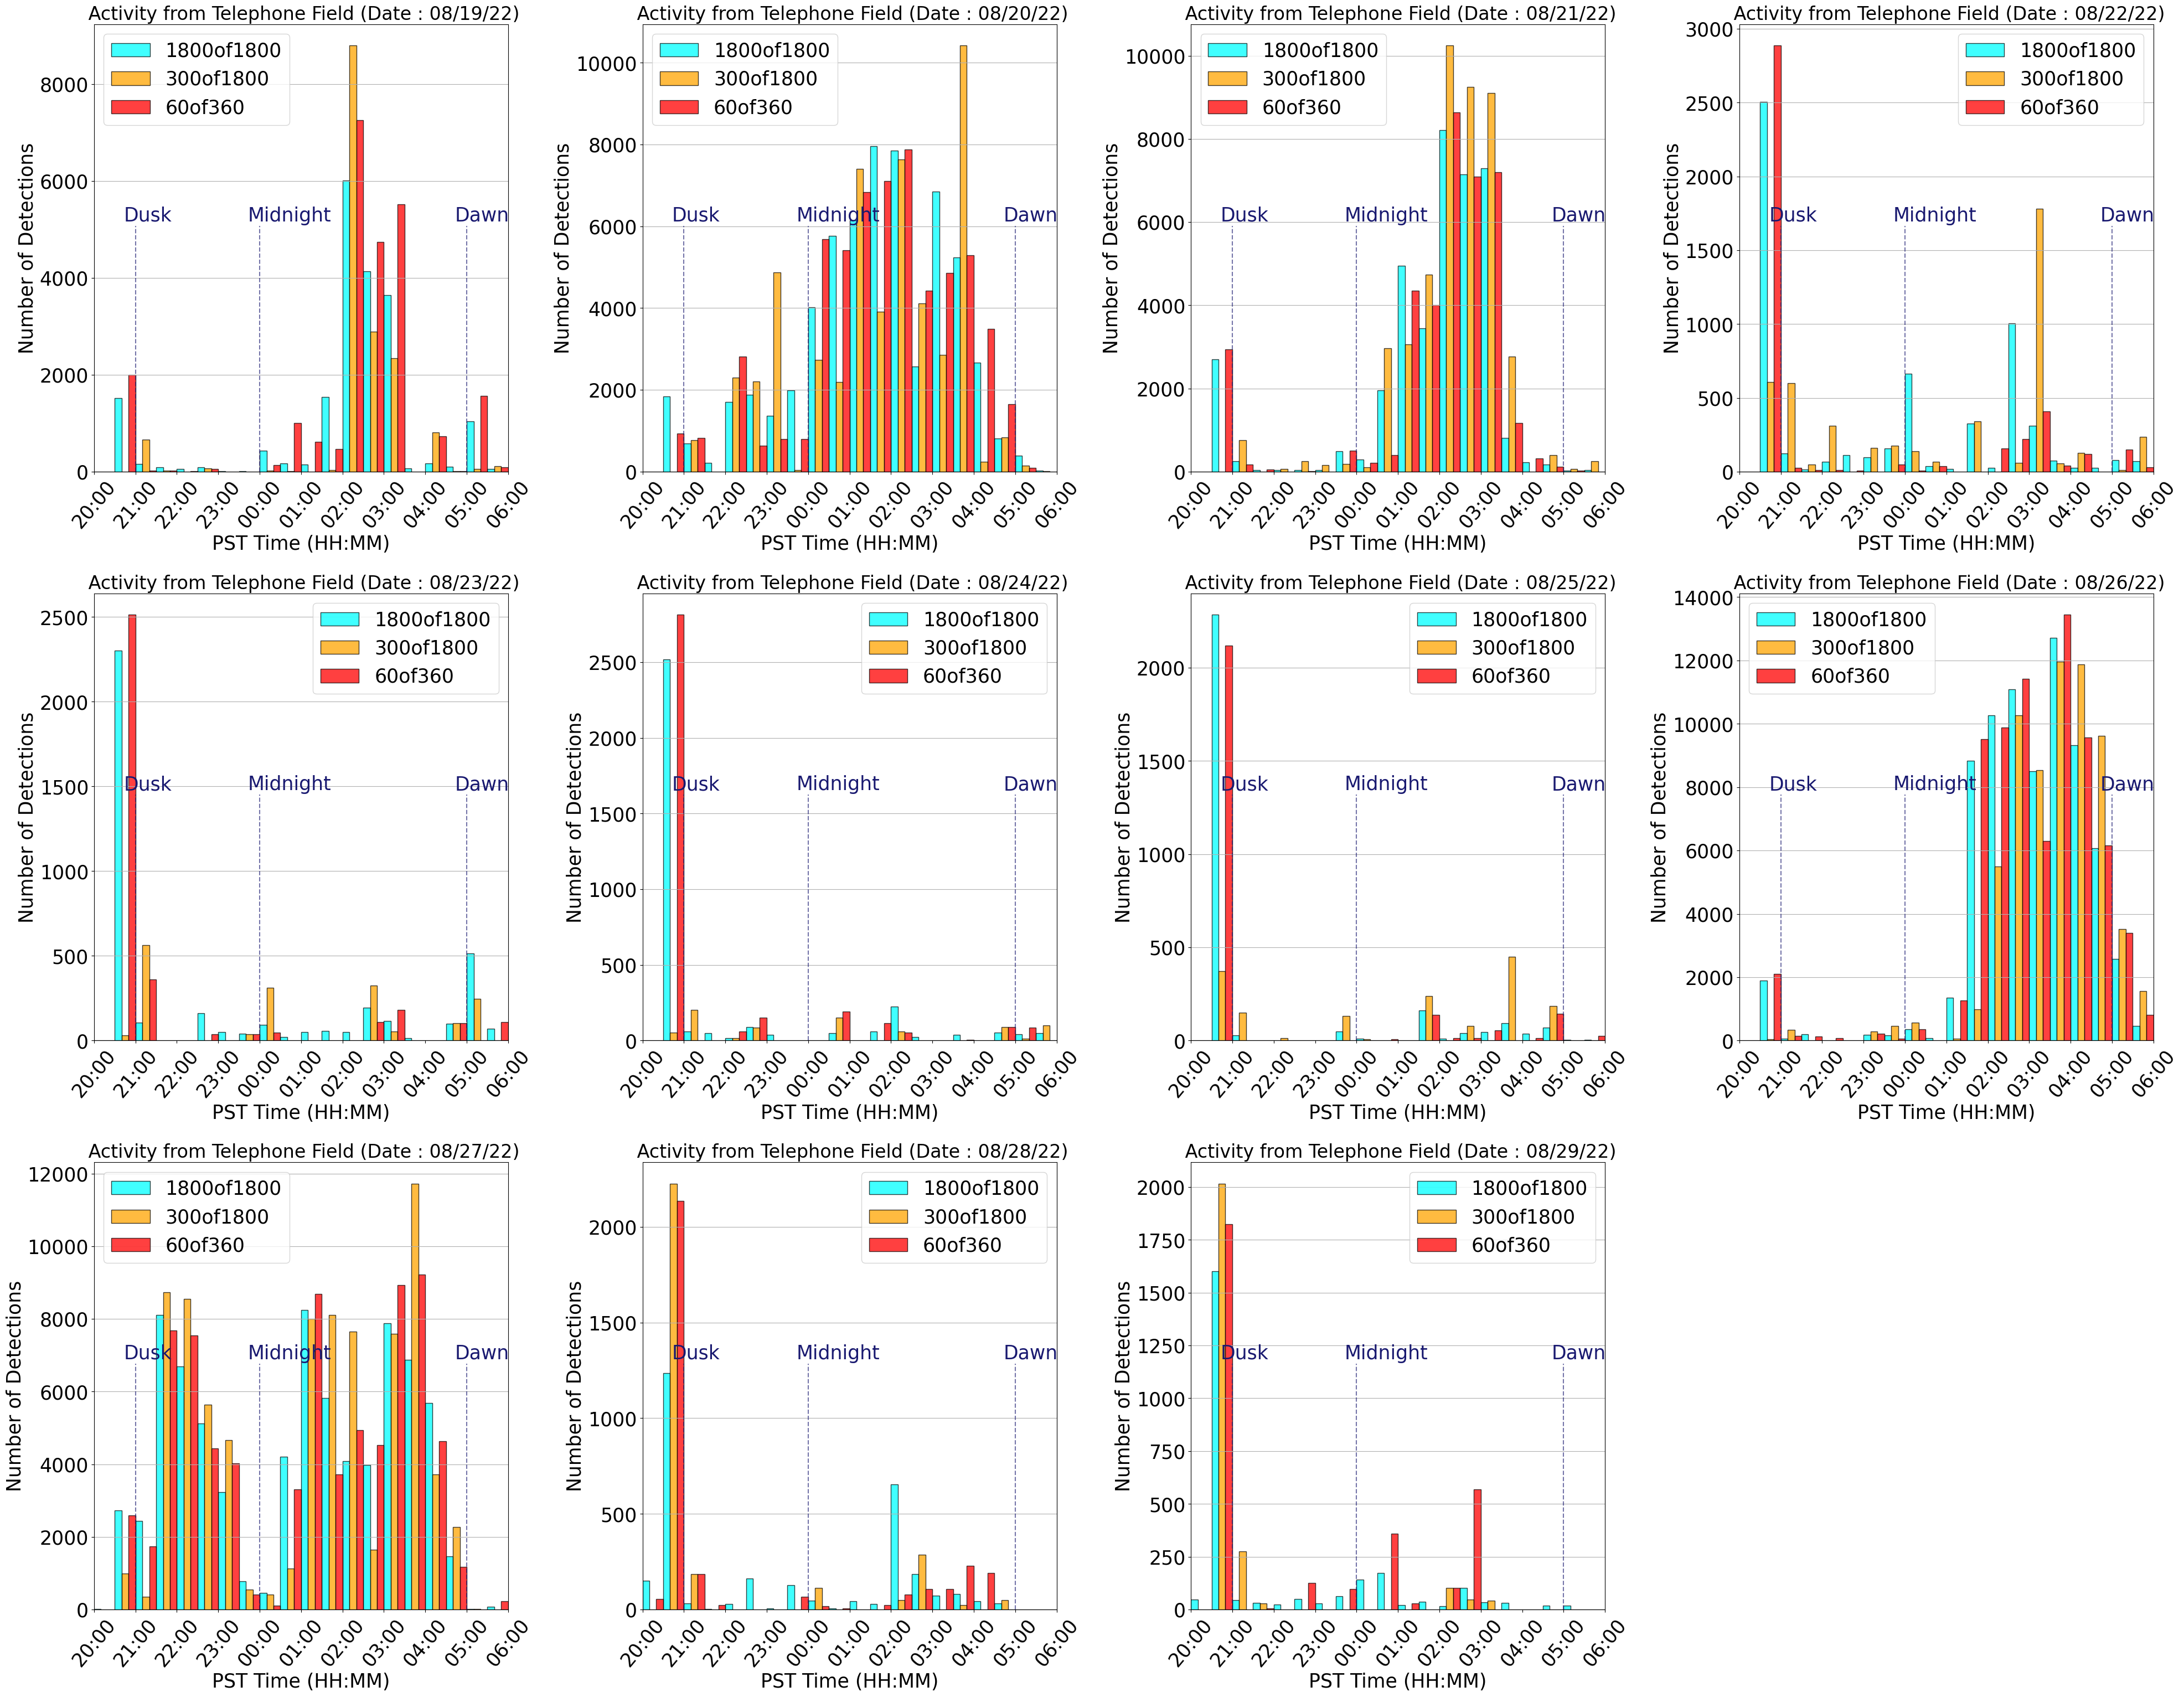

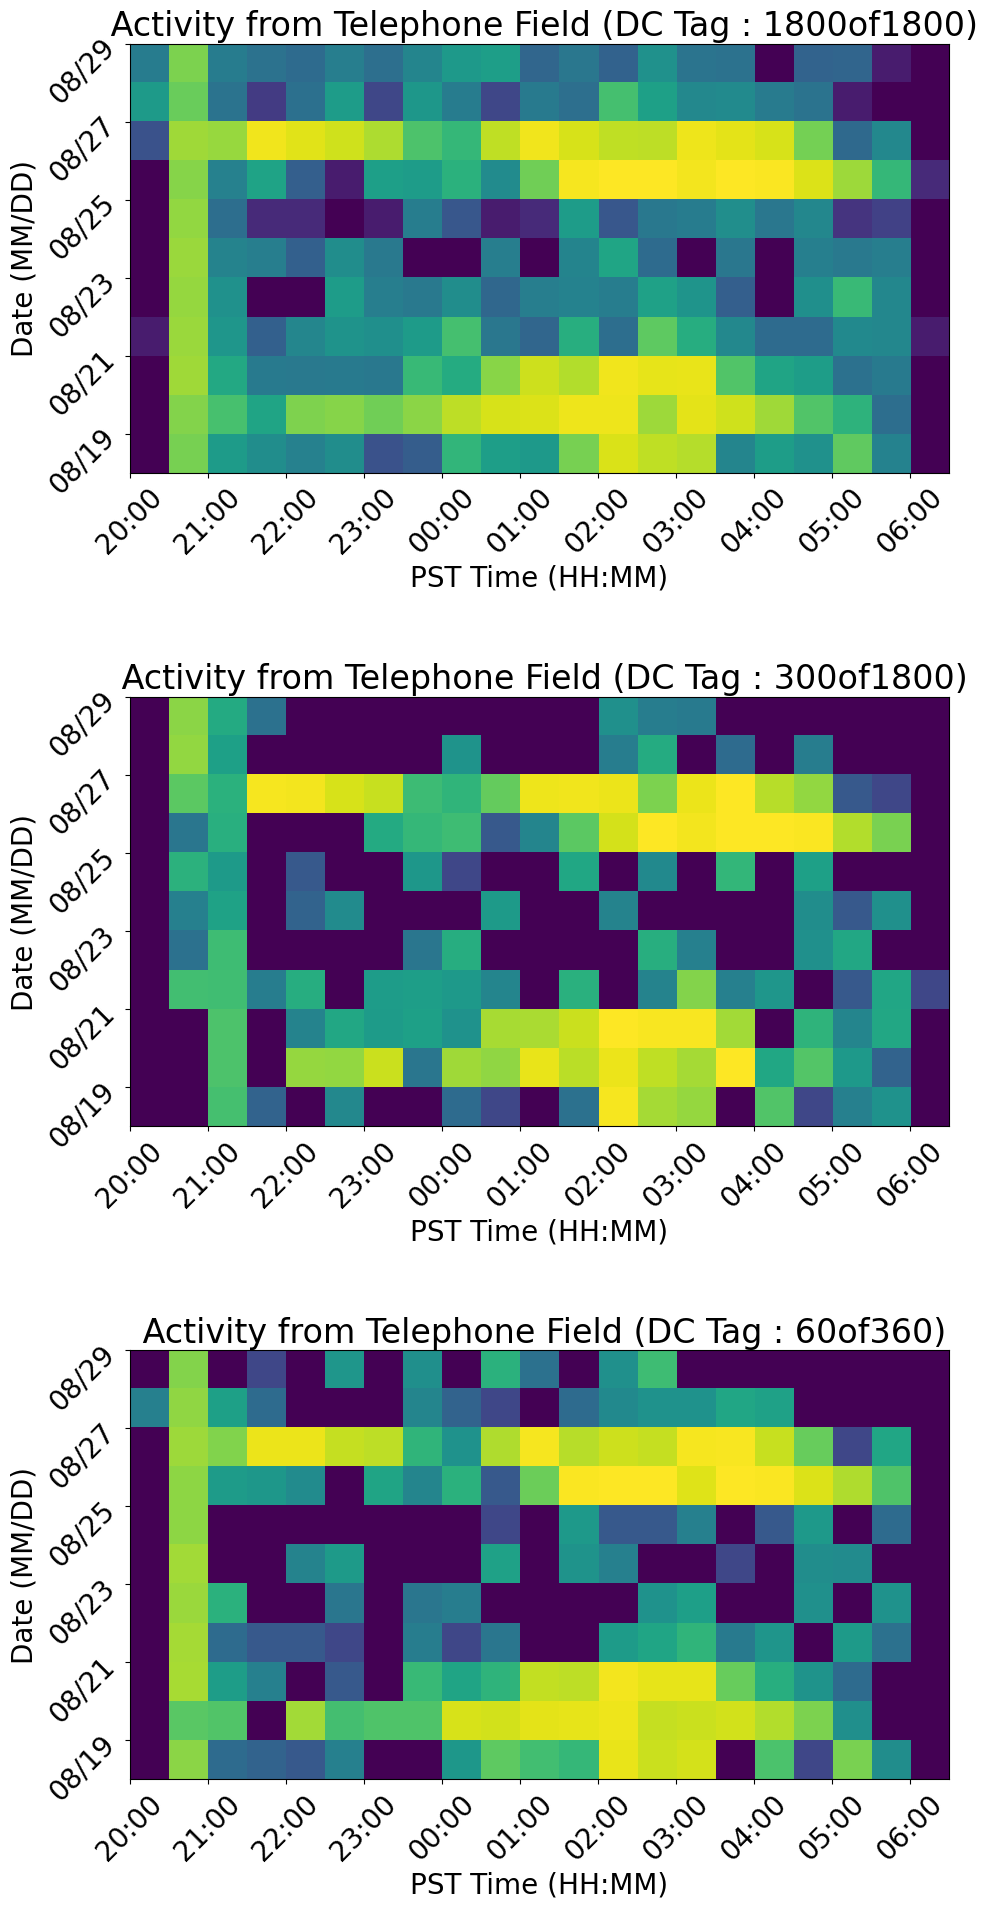

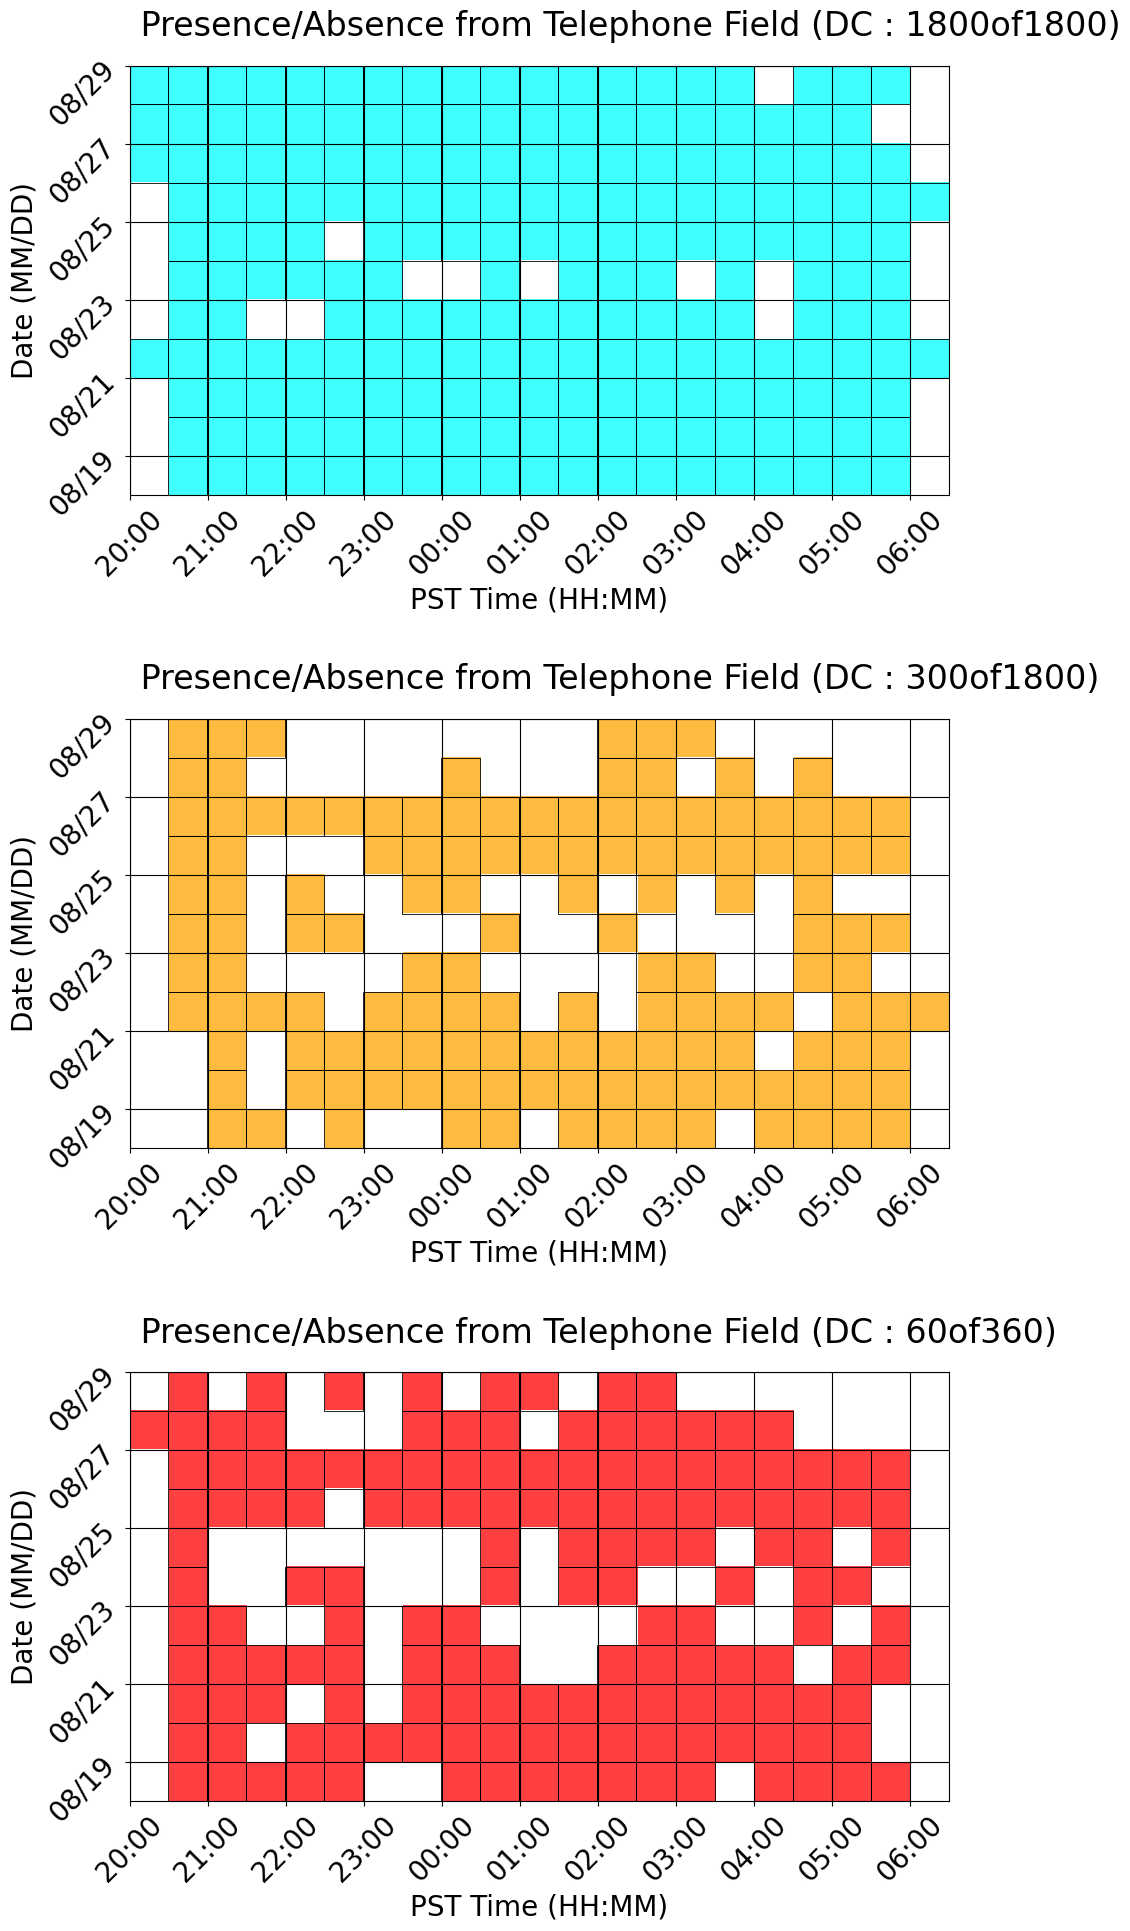

In [8]:
pipeline.run(data_params, cfg)